# Final Project
Quinn Frank <br>
November 23, 2020

In [31]:
# Import NLTK to load training data
import nltk
nltk.download("tagsets")
nltk.download("brown")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
# Potentially: http://www.anc.org/software/anc-tool/

# Import my modules
from hmm import HMM
from blstm import *
from tagging_results import TaggingResults

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# CAN LOAD PRE-TRAINED MODELS HERE

def enpickle(obj, file):
    import pickle
    with open(file, 'wb') as out_file:
        pickle.dump(obj, out_file)

def unpickle(file):
    import pickle
    with open(file, 'rb') as in_file:
        pickle_dict = pickle.load(in_file, encoding='bytes')
    return pickle_dict

#hmm = unpickle("models/hmm")
#summ = unpickle("models/blstm_train_summ")
#net = torch.load("models/blstm")

## Step 2: Generative Model

In [34]:
train_size, test_size = 30000, 5000   # actual test set may be < test_size
train = nltk.corpus.brown.tagged_sents(tagset="universal")[:train_size]
test = nltk.corpus.brown.tagged_sents(tagset="universal")[train_size:train_size+test_size]

In [45]:
hmm = HMM()
%time hmm.fit(train)
%time test_sents, y_true, y_predict = hmm.split_predict(test)    # time this

Wall time: 5min 51s
Wall time: 11.8 s


In [46]:
# Calculate accuracy of HMM on both datasets
hmm_train = TaggingResults(hmm, train, hmm.vocab, hmm.tagset)
hmm_test = TaggingResults(hmm, test, hmm.vocab, hmm.tagset)

hmm_train.get_accuracy()
hmm_test.get_accuracy()


Accuracy
--------
total               0.9750
in vocab            0.9750
out of vocab           NaN
ambiguous tokens    0.9491
dtype: float64

Accuracy
--------
total               0.9346
in vocab            0.9719
out of vocab        0.2673
ambiguous tokens    0.8974
dtype: float64


## Step 3: Discriminative Model

In [35]:
untagged_train = nltk.corpus.brown.sents()[:train_size]
%time embedder = train_fasttext(untagged_train)

# Also store the vocabulary for later
net_vocab = pd.Index(sorted(set(sum(untagged_train, []))))

Wall time: 17.7 s


In [42]:
train_set = POSDataset(train, embedder, hmm.tagset)
test_set = POSDataset(test, embedder, hmm.tagset)

# Network is loaded onto a GPU by default
# (to run on cpu, remove .cuda() and set use_cuda below to False)
net = BLSTM(100, len(hmm.tagset), 128, 2, 0.2)

In [43]:
net.cuda()
%time summ = train_BLSTM(net, train_set, test_set, \
                         num_epochs=40, batch_size=16, use_cuda=True, \
                         print_every=1, train_summ=None, \
                         opt_params={'lr': 0.1, 'momentum': 0.8})

- EPOCH 1:
  train loss = 0.5588613748550415
  accuracy   = 0.9066 (train) / 0.9106 (test)
----------------------------
- EPOCH 2:
  train loss = 0.4956792891025543
  accuracy   = 0.9256 (train) / 0.9258 (test)
----------------------------
- EPOCH 3:
  train loss = 0.4926051199436188
  accuracy   = 0.9336 (train) / 0.9331 (test)
----------------------------
- EPOCH 4:
  train loss = 0.47339779138565063
  accuracy   = 0.9387 (train) / 0.9374 (test)
----------------------------
- EPOCH 5:
  train loss = 0.48047271370887756
  accuracy   = 0.9424 (train) / 0.9394 (test)
----------------------------
- EPOCH 6:
  train loss = 0.4446640610694885
  accuracy   = 0.9454 (train) / 0.9427 (test)
----------------------------
- EPOCH 7:
  train loss = 0.4515708088874817
  accuracy   = 0.948 (train) / 0.9446 (test)
----------------------------
- EPOCH 8:
  train loss = 0.46215829253196716
  accuracy   = 0.95 (train) / 0.9466 (test)
----------------------------
- EPOCH 9:
  train loss = 0.433892637491

Wall time: 5.02 s


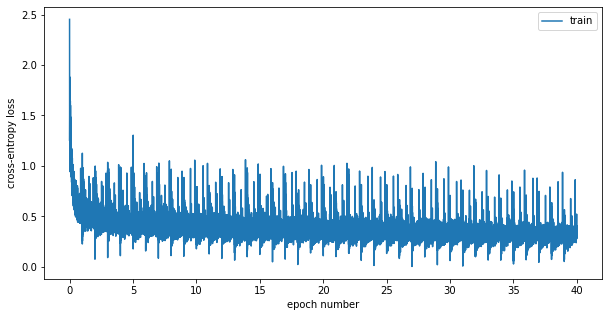

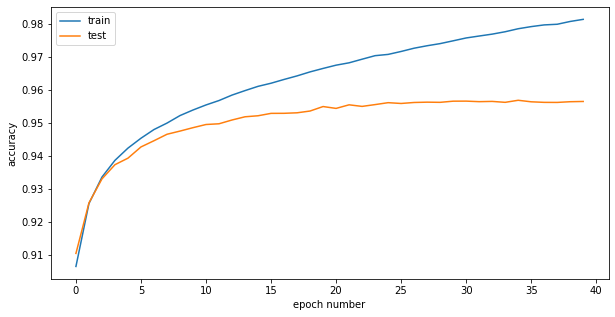


Accuracy
--------
total               0.9793
in vocab            0.9793
out of vocab           NaN
ambiguous tokens    0.9816
dtype: float64

Accuracy
--------
total               0.9543
in vocab            0.9622
out of vocab        0.8269
ambiguous tokens    0.9334
dtype: float64


In [44]:
net.cpu()
%time test_sents, y_true, y_predict = net.split_predict(test_set)   # time this
plot_train_summ(summ)

# Calculate accuracy of BiLSTM on both datasets
net_train = TaggingResults(net, train, net_vocab, hmm.tagset, embedder)
net_test = TaggingResults(net, test, net_vocab, hmm.tagset, embedder)

net_train.get_accuracy()
net_test.get_accuracy()

In [47]:
# STORE MODELS HERE ONCE TRAINED

#enpickle(hmm, "models/hmm")
#enpickle(summ, "models/blstm_train_summ")
#torch.save(net, "models/blstm")

# Step 4: Application to Artificial Data

In [48]:
# Generate an artificial tagged dataset to test on
%time artificial = hmm.generate(1000)

Wall time: 20.3 s


In [49]:
# Calculate the accuracy on the artifical dataset
hmm_art = TaggingResults(hmm, artificial, hmm.vocab, hmm.tagset)
net_art = TaggingResults(net, artificial, net_vocab, hmm.tagset, embedder)

hmm_art.get_accuracy()
net_art.get_accuracy()


Accuracy
--------
total               0.9754
in vocab            0.9754
out of vocab           NaN
ambiguous tokens    0.8890
dtype: float64

Accuracy
--------
total               0.8793
in vocab            0.8860
out of vocab        0.7560
ambiguous tokens    0.7833
dtype: float64


In [20]:
net_art.get_sent(5)

           true predict correct? oov? ambiguous?
token                                           
means      NOUN    NOUN        ✓               *
keyed      VERB    VERB        ✓                
be         VERB    VERB        ✓                
much        ADJ     ADV                        *
moore      NOUN     ADV             *           
as          ADP     ADP        ✓               *
witty       ADJ    NOUN                         
on          ADP     ADP        ✓               *
direction  NOUN    NOUN        ✓                
except      ADP    NOUN                         
army       NOUN    NOUN        ✓                
is         VERB    VERB        ✓                
family     NOUN    VERB                         
``            .       .        ✓                
the         DET     DET        ✓                
acres      NOUN    NOUN        ✓                
also        ADV     ADV        ✓                
is         VERB    VERB        ✓                
had        VERB    V

# Step 5: Application to Real Data

### Moby-Dick

In [65]:
import re
from nltk.tag import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize

In [23]:
# Let NLTK annotate (tokenize and tag)
moby_words = nltk.corpus.gutenberg.words("melville-moby_dick.txt")
moby = list(map(lambda sent: pos_tag(word_tokenize(sent), tagset='universal'),
                sent_tokenize(' '.join(moby_words))))

In [24]:
# Calculate the accuracy on Moby-Dick
hmm_moby = TaggingResults(hmm, moby, hmm.vocab, hmm.tagset)
net_moby = TaggingResults(net, moby, net_vocab, hmm.tagset, embedder)

hmm_moby.get_accuracy()
net_moby.get_accuracy()


Accuracy
--------
total               0.8038
in vocab            0.8743
out of vocab        0.2800
ambiguous tokens    0.7766
dtype: float64

Accuracy
--------
total               0.7927
in vocab            0.8160
out of vocab        0.6475
ambiguous tokens    0.6117
dtype: float64


In [30]:
net_moby.get_sent(10000)

           true predict correct? oov? ambiguous?
token                                           
So          ADV     ADV        ✓               *
,             .       .        ✓                
floating   VERB    VERB        ✓               *
on          ADP     ADP        ✓                
the         DET     DET        ✓                
margin     NOUN    NOUN        ✓                
of          ADP     ADP        ✓                
the         DET     DET        ✓                
ensuing    VERB    VERB        ✓               *
scene      NOUN    NOUN        ✓                
,             .       .        ✓                
and        CONJ    CONJ        ✓                
in          ADP     ADP        ✓                
full        ADJ     ADJ        ✓                
sight      NOUN    NOUN        ✓               *
of          ADP     ADP        ✓                
it         PRON    PRON        ✓                
,             .       .        ✓                
when        ADV     

### Trump Tweets

In [78]:
def convert_tweet(tweet):
    """Given a string (which may contain multiple sentences),
       splits into sentences, tokenizes each, and automatically tags with NLTK.
       Also removes hyperlinks and @ references."""
    
    to_remove = r"http\S*\b|@|#"
    tweet = re.sub(to_remove, " ", tweet)
    tweet_sents = sent_tokenize(tweet)
    tag = lambda sent: pos_tag(word_tokenize(sent), tagset='universal')
    tweet_data = list(map(tag, tweet_sents))
    return tweet_data

# Compile a compatible training set from the downloaded tweets
trump_tweets = pd.read_json("data/trump10.json", encoding="utf8")
trump = sum(list(map(convert_tweet, trump_tweets.text)), [])

In [79]:
trump

[[('I', 'PRON'),
  ('was', 'VERB'),
  ('thrilled', 'VERB'),
  ('to', 'PRT'),
  ('be', 'VERB'),
  ('back', 'ADV'),
  ('in', 'ADP'),
  ('my', 'PRON'),
  ('home', 'NOUN'),
  ('state', 'NOUN'),
  ('of', 'ADP'),
  ('FLORIDA', 'NOUN'),
  ('!', '.')],
 [('5', 'NUM'),
  ('days', 'NOUN'),
  ('from', 'ADP'),
  ('now', 'ADV'),
  (',', '.'),
  ('we', 'PRON'),
  ('are', 'VERB'),
  ('going', 'VERB'),
  ('to', 'PRT'),
  ('win', 'VERB'),
  ('FLORIDA', 'NOUN'),
  (',', '.'),
  ('and', 'CONJ'),
  ('we', 'PRON'),
  ('are', 'VERB'),
  ('going', 'VERB'),
  ('to', 'PRT'),
  ('WIN', 'VERB'),
  ('4', 'NUM'),
  ('more', 'ADJ'),
  ('years', 'NOUN'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('White', 'NOUN'),
  ('House', 'NOUN'),
  ('.', '.')],
 [('Get', 'VERB'),
  ('out', 'PRT'),
  ('and', 'CONJ'),
  ('VOTE', 'NOUN'),
  ('!', '.')],
 [('MAKE', 'NOUN'),
  ('AMERICA', 'NOUN'),
  ('GREAT', 'NOUN'),
  ('AGAIN', 'NOUN'),
  ('!', '.')],
 [('!', '.')],
 [('THANK', 'NOUN'),
  ('YOU', 'NOUN'),
  ('TAMPA', 'NOUN'),
  (',', '

In [73]:
# Calculate the accuracy on Moby-Dick
hmm_trump = TaggingResults(hmm, trump, hmm.vocab, hmm.tagset)
net_trump = TaggingResults(net, trump, net_vocab, hmm.tagset, embedder)

hmm_trump.get_accuracy()
net_trump.get_accuracy()


Accuracy
--------
total               0.7856
in vocab            0.8600
out of vocab        0.1122
ambiguous tokens    0.7278
dtype: float64

Accuracy
--------
total               0.8165
in vocab            0.8843
out of vocab        0.5103
ambiguous tokens    0.6032
dtype: float64
